# Model data preparation

This code transform the data into an appropriate format for stan model. First it  aggregates and standardises the values of present environmental variables and data on buckwheat production for each county in China, and saves it into a csv file. It also merges the data with the spatail polygons for counties, to show the values on the plots. Then it also caluclates and saves the adjacency matrix for Chinese counties to be used in iCAR model


In [1]:
# Load libraries:
library(rgdal) # working with spatial data
library(raster) # working with later layers
library(data.table) # working with data frames
library(spdep) # calculating the adjacency matrix
require(geosphere) # calculating polygon area
library(here) # setting paths
library(viridis) # for visualisation
library(RColorBrewer) # for visualisation
library(tmap) # for thematic mapping
library(cultevo) #for visualisation

Loading required package: sp

rgdal: version: 1.5-18, (SVN revision 1082)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: D:/Programs/R-4.0.3/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: D:/Programs/R-4.0.3/library/rgdal/proj
Linking to sp version:1.4-4
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.


Attaching package: 'data.table'


The following object is masked from 'package:raster':

    shift


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sf

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1

Loa

ERROR: Error in library(cultevo): there is no package called 'cultevo'


In [3]:
### Set the paths for loading data

# Masked data on buckwheat production in China (masked to keep the data consistent:
path2prd<-here("data","buckwheat_production","masked")

# Environmental variables (cropped, because the border cells will have a consistent quality:
path2env <-here("data","environmental","present","masked")

# Get path to past environmental data:
path2past <- here("data","environmental","past")

# Get path to Chinese counties:
path2counties<-here("raw_data","CHN_adm")

# Path to full names of environmental variables:

path2env_table<-here("outputs","01_03_Predictor_variables.csv")

### Set the paths for outputs:
path2envRaster<-here("outputs","03_01_Predictors_raster.png")
path2env_counties<-here("data","Env_by_county.csv")
path2envMaps<-here("outputs","03_02_Predictors.png")
path2envMapsAE<-here("outputs","03_02")
path2stats<- here("outputs","03_03_Env_Mean_and_SD.csv")
path2env_sd<- here("data","Sd_Env_by_county.csv")
path2prd_counties<-here("data","Prd_by_county.csv")
path2adjacency <- here("data","china_data","adjacency.csv")

In [7]:
# Loading data:
var_names=c("BIO10","BIO17","BIO4","BIO9","npp")
# Get vector map of Chinses counties
china<-readOGR(dsn = path2counties, layer = "CHN_adm3")
outer_border<-readOGR(dsn = path2counties, layer = "CHN_adm0")

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\SDM_China\raw_data\CHN_adm", layer: "CHN_adm3"
with 2409 features
It has 13 fields
Integer64 fields read as strings:  ID_0 ID_1 ID_2 ID_3 
OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\SDM_China\raw_data\CHN_adm", layer: "CHN_adm0"
with 1 features
It has 70 fields
Integer64 fields read as strings:  ID_0 OBJECTID_1 


In [8]:
# Get production dataset for China:
prd_layers<-list.files(path=path2prd,pattern='tif$',full.names=TRUE)
layers<-list.files(path=path2env,pattern='tif$',full.names=TRUE)
# Get only the environmental layers that are not autocorrelated:
env_layers<-subset(layers,lapply(layers, grepl,pattern=paste(var_names,collapse="|"))==TRUE)
past_layers<-list.files(path=here(path2past,var_names,"masked"),pattern='tif$',full.names=TRUE)
prd<-stack(prd_layers)
env<-stack(c(env_layers,past_layers))

In [9]:
# Get the full names of environmental variables
env_table<-read.csv(path2env_table,row.names = 1)

## Plot predictors in the original (raster) format.

This code pepares the visualisation of selected variables in the original (raster) format to inspect them.

In [10]:
# Set the colour schemes for the plots of environmental data
my_col<-c()
my_col[[1]]<-rev(brewer.pal(n = 9, name = "RdYlBu"))
my_col[[2]]<-rev(brewer.pal(n = 9, name = "RdYlBu"))
my_col[[3]]<-brewer.pal(n = 9, name = "Reds")
my_col[[4]]<-viridis(10)
my_col[[5]]<-brewer.pal(n = 9, name = "YlGnBu")

In [11]:
plot_order<-c(4,1,3,5,2)

In [12]:
var_names<-names(env[[plot_order]])

In [13]:
# Set the names of the layers
full_names<-env_table[var_names,]

In [14]:
# Set the legend names
legends<-list("°C","°C","°C","g C m^−2 yr^−1","mm")

In [124]:
# Prepare the plot of the predictors
env_raster<-tm_shape(env[[plot_order]]) +
    tm_grid(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.8)+
    tm_raster(style="cont",palette=my_col,legend.reverse = TRUE,title=legends)+
    tm_facets(free.scales=TRUE,free.scales.raster=TRUE,ncol=2,nrow=3)+
    tm_layout(panel.labels=full_names,
              panel.label.bg.color="white",
              frame=FALSE,
              frame.lwd = NA,
              legend.position=c("left","bottom"),
              panel.label.fontface = "bold",
              panel.label.height=2,
              panel.label.size = 1,
              legend.text.size = 0.6
              )

In [125]:
# Save the plot
width=21
height=29.7*0.75
tmap_save(tm = env_raster,filename = path2envRaster,width = width,height = height,units = "cm",dpi = 300)

Variable(s) "NA" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

Variable(s) "NA" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

Map saved to G:\My Drive\SDM_China\outputs\03_01_Predictors_raster.png

Resolution: 2480.315 by 2630.906 pixels

Size: 8.267717 by 8.769685 inches (300 dpi)



## Aggregate the values of environmental predictors by county

### Get mean values per county

In [29]:
### Get the values of environmental variables per county: 
# Extract raster values of the cells for environmental variables for each county in China
r.vals <- extract(env,china,weights=TRUE,normalizeWeights=TRUE)

In [31]:
# Calculate the mean value of each of the environmental variables per county in china
r.means<-lapply(r.vals,function(x){apply(rbind(x[,c(1:ncol(x)-1)]),2,weighted.mean,w=x[,ncol(x)],na.rm=TRUE)})
## Calculate the weighted mean:
r.means<-lapply(r.vals,function(x){apply(rbind(x[,c(1:ncol(x)-1)]),2,weighted.mean,w=x[,ncol(x)],na.rm=TRUE)})
r.mean<-lapply(r.means, rbind)
r.mean<-lapply(r.mean,as.data.frame)
r.mean<- rbindlist(r.mean)

In [32]:
# Get the counties with missing values, because they don't overlap with eny of the raster cells:
sums<-rowSums(r.mean)
mc<-which(is.na(sums))

In [33]:
# Create a raster stack of environmental variables with a buffer zone around the coast
# to include the counties with missing values
buffer <- stack()
for (i in 1:length(names(env))){
    focal<-focal(env[[i]],w=matrix(1,3,3), fun=mean,na.rm=TRUE,NAonly=TRUE)
    names(focal)<-names(env[[i]])
    buffer<-stack(buffer,focal)
}

In [34]:
# Extract the values from the buffer zone:
buffer.vals <- extract(buffer,china[mc,],weights=TRUE,normalizeWeights=TRUE)
buffer.means<-lapply(buffer.vals,function(x){apply(rbind(x[,c(1:ncol(x)-1)]),2,weighted.mean,w=x[,ncol(x)],na.rm=TRUE)})
buffer.mean<-lapply(buffer.means, rbind)
buffer.mean<-lapply(buffer.mean,as.data.frame)
buffer.mean<- rbindlist(buffer.mean)

In [35]:
# Substitute newly calculated values for NAs
r.mean[mc,] <-buffer.mean

In [122]:
r.mean<-as.data.frame(r.mean)

In [38]:
write.csv(r.mean,path2env_counties)

## Plot environmental variables for all time periods

In [15]:
r.mean<-read.csv(path2env_counties,row.names=1)
# Merge the data frame with the spatial polygons
china@data <- data.frame(china@data, r.mean)

In [16]:
# Plot predictions for current data
env_maps<-tm_shape(china) +
    tm_grid(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.8)+
    tm_fill(col=var_names,n=5, style = "cont",palette=my_col,title=legends,legend.reverse = TRUE,showNA = F) +
    tm_shape(outer_border)+
    tm_borders(col="grey",lwd=0.5)+
    tm_facets(free.scales=TRUE,free.coords=TRUE,ncol=2,nrow=3)+
    tm_layout(panel.labels=full_names,
              panel.label.bg.color="white",
              frame=FALSE,
              frame.lwd=NA,
              legend.position=c("left","bottom"),
              panel.label.fontface = "bold",
              panel.label.height=2,
              panel.label.size = 1,
              legend.text.size = 0.6,
              legend.height=0.25)

In [133]:
# Save the plot
width=21
height=29.7*0.75
tmap_save(tm = env_maps,filename = path2envMaps,width = width,height = height,units = "cm",dpi = 300)


Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Variable(s) "BIO9_7000" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

Map saved to G:\My Drive\SDM_China\outputs\03_02_Predictors.png

Resolution: 2480.315 by 2630.906 pixels

Size: 8.267717 by 8.769685 inches (300 dpi)



In [18]:
letters<-c("a","b","c","d","e")

In [19]:
# Set the letters list for names
letters<-c("a","b","c","d","e")
# Loop over all the environmental variables and plot them for all timeslices
for (i in c(2:5)){
    col_names<-colnames(china@data)[grep(var_names[i],colnames(china@data))]
    period_labels<-gsub(paste(var_names[i],"_",sep=""),"",col_names)
    t=legends[i]
    l=letters[i]
    env_maps<-tm_shape(china) +
        tm_grid(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.8)+
        tm_fill(col=col_names, title=t,style = "cont",n=4,legend.reverse = TRUE,palette=my_col[[i]],showNA = F) +
        tm_shape(outer_border)+
        tm_borders(col="grey",lwd=0.5)+
        tm_facets(free.scales=TRUE,free.coords=TRUE,ncol=2,nrow=4)+
        tm_layout(panel.labels=period_labels,
              panel.label.bg.color="white",
              frame=FALSE,
              frame.lwd=NA,
              legend.position=c("left","bottom"),
              panel.label.fontface = "bold",
              panel.label.height=1.5,
              panel.label.size = 1,
              legend.text.size = 0.6,
              legend.height=0.5)

    # Save the plot
    width=21
    height=29.7
    tmap_save(tm = env_maps,filename = paste(path2envMapsAE,l,var_names[i],".png",sep=""),width = width,height = height,units = "cm",dpi = 300)
}

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Map saved to G:\My Drive\SDM_China\outputs\03_02bBIO10.png

Resolution: 2480.315 by 3507.874 pixels

Size: 8.267717 by 11.69291 inches (300 dpi)

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Map saved to G:\My Drive\SDM_China\outputs\03_02cBIO4.png

Resolution: 2480.315 by 3507.874 pixels

Size: 8.267717 by 11.69291 inches (300 dpi)

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Map saved to G:\My Drive\SDM_China\outputs\03_02dnpp.png

Resolution: 2480.315 by 3507.874 pixels

Size: 8.267717 by 11.69291 inches (300 dpi)

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Map saved to G:\My Drive\SDM_China\outputs\03_02eBIO17.png

Resolution: 2480.315 by 3507.874 pixels

Size: 8.267717 by 11.69291 inches (300 dpi)



## Standardise environmental variables

In [ ]:
# Standardise environmental variables
# Get the mean and standard deviation of all the bioclimatic variables that will be used in a model:
stats<-lapply(var_names,function(x){
var_stack <- subset(env,colnames(china@data[grep(x,colnames(china@data))]))
vals<-as.vector(values(var_stack))
mean<-mean(vals, na.rm=TRUE)
sd<-sd(vals, na.rm=TRUE)
return(as.data.frame(cbind(mean,sd)))})

# Get the mean and standard deviations of the environmental variables into a dataframe
stats<-rbindlist(stats)
stats<-as.data.frame(stats)

# Name the rows according to the names of the environmental variables
rownames(stats) <- var_names

# Save the mean and standard deviation used for scaling and centering of the variables:
write.csv(stats, file=path2stats)

In [136]:
# Standardize data
std_data<-lapply(var_names,function(x){
    data_sub<-r.mean[,grep(x,colnames(r.mean))]
    new_columns<-scale(data_sub,center=rep(stats[x,]$mean,ncol(data_sub)),scale=rep(stats[x,]$sd,ncol(data_sub)))
    new_columns<-as.data.frame(new_columns)
    colnames(new_columns)<-paste(colnames(new_columns),"sd",sep="_")
    return(new_columns)})

In [139]:
# Format standardised data as a data frame
std_data<-data.frame(std_data)

In [144]:
write.csv(std_data,path2env_sd)

## Extract and standardise values for production for all counties

In [ ]:
# Extract raster values of the cells with data on buckwheat production for each county in China
r.vals <- extract(prd,china)

In [ ]:
# Calculate either mean values, or sums for the variables related to buckwheat production for each county
r.mean<-lapply(r.vals,function(x){
HarvestedAreaDataQuality<- names(sort(table(x[,1]),decreasing=TRUE))[1]
YieldDataQuality<- names(sort(table(x[,2]),decreasing=TRUE))[1]
HarvestAreaFraction<-mean(x[,3],na.rm=TRUE)
HarvestedAreasHectaresSum<-sum(x[,4],na.rm=TRUE)
HarvestedAreasHectaresMean<-mean(x[,4],na.rm=TRUE)
ProductionSum<-sum(x[,5],na.rm=TRUE)
ProductionMean<-mean(x[,5],na.rm=TRUE)
YieldPerHectare<-mean(x[,6],na.rm=TRUE)
df<-cbind(HarvestedAreaDataQuality,YieldDataQuality,HarvestAreaFraction,HarvestedAreasHectaresSum,HarvestedAreasHectaresMean,ProductionSum,ProductionMean,YieldPerHectare)
return(df)})

In [ ]:
# Turn the extracted values into one data frame
r.mean<-lapply(r.mean, rbind)
r.mean<-lapply(r.mean,as.data.frame)
r.mean<- rbindlist(r.mean)

In [41]:
write.csv(r.means,path2prd_counties)

In [20]:
d<-readOGR(dsn =here("data","china_data"), layer = "china_data")

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\SDM_China\data\china_data", layer: "china_data"
with 2409 features
It has 36 fields


In [ ]:
### Change colnames to shorter onse before attaching them to the spatial polygons datafram, so that they are not cut when 
### writing it to the file
colnames(r.mean)<-c("AreaDQ","YieldDQ","AreaFr","AreaHaS","AreaHaM","ProdSum","ProdMean","YieldPH")
### Attach the dataframe to the attributes of the spatial polygons
china@data <- data.frame(china@data, r.mean)

In [42]:
### Calculate the area of each 
china@data$area<-areaPolygon(china)

In [43]:
head(china@data$area)

[1]  458885245 1611724621 1711132484 2354233624 2025878814 1647492859

In [ ]:
### Get the prortion of area which is cultivated, by dividing the cultivated area in hectares for the county, by the area of 
### the county. Area is given in square meters, and cultivated area in hectares, so multiply by 10 000.
china@data$AreaPr<-(as.numeric(as.character(china@data$AreaHaS))/china@data$area)*10000

### Get the average produciont of buckwheat in tonnes, per hectar of a county
china@data$ProdHa<-(as.numeric(as.character(china@data$ProdSum))/china@data$area)*10000

In [ ]:
### Get the smallest possible values of AreaPr and Prod Ha:
sort(unique(china@data$AreaPr))[2]
sort(unique(china@data$ProdHa))[2]

In [ ]:
### Get the logarithms for the proportion of the area of the county where buckwheat is cultivatad 
### and for average production in tonnes per hectare in a country.
### To transform into a logarithm add a small value 
### (a magnitude smaller than the second smallest value in the column)
### to all of the numbers to avoind zeros:
china@data$logArea <- log(china@data$AreaPr+1e-11 )
china@data$logProd <- log(china@data$ProdHa+1e-11)

###Change the names so the they are not transformed when written to a file:
colnames(china@data)<- gsub("0","",colnames(china@data))
colnames(china@data)<-gsub("BIO1_","BIO10_",colnames(china@data))
colnames(china@data)[1] <- "ID_0"

In [32]:
### Write the Spatial Polygon data frame to a file:
writeOGR(obj=china, dsn="data/china_data", layer="china_data", driver="ESRI Shapefile")

In [56]:
china_sf <-  st_read("data/china_data", quiet = TRUE)

In [57]:
china_sf<-st_union(china_sf)

In [6]:
china<-readOGR(dsn="data/china_data", layer="china_data")

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\SDM_China\data\china_data", layer: "china_data"
with 2409 features
It has 36 fields


In [10]:
str(china@data)

'data.frame':	2409 obs. of  36 variables:
 $ ID_0     : Factor w/ 1 level "49": 1 1 1 1 1 1 1 1 1 1 ...
 $ ISO      : Factor w/ 1 level "CHN": 1 1 1 1 1 1 1 1 1 1 ...
 $ NAME_0   : Factor w/ 1 level "China": 1 1 1 1 1 1 1 1 1 1 ...
 $ ID_1     : Factor w/ 31 levels "1","10","11",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ NAME_1   : Factor w/ 31 levels "Anhui","Beijing",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ID_2     : Factor w/ 344 levels "1","10","100",..: 1 1 1 1 1 1 1 1 1 112 ...
 $ NAME_2   : Factor w/ 339 levels "Aksu","Altay",..: 5 5 5 5 5 5 5 5 5 24 ...
 $ ID_3     : Factor w/ 2409 levels "1","10","100",..: 1 1112 1633 1744 1855 1966 2077 2188 2299 2 ...
 $ NAME_3   : Factor w/ 2228 levels "Aba","Abag","Abagnar Qi",..: 25 633 1326 1594 1607 1661 1705 2084 2221 96 ...
 $ TYPE_3   : Factor w/ 12 levels "QÃ­","ShÃ¬xiÃ¡q?",..: 7 6 6 6 6 7 6 6 6 7 ...
 $ ENGTYPE_3: Factor w/ 11 levels "Administrative Committee",..: 7 6 6 6 6 7 6 6 6 7 ...
 $ NL_NAME_3: Factor w/ 19 levels "??","???","????",..: NA 2 2 2 

In [22]:
china2<-china

In [24]:
china@data[,c("AreaFr","logArea","AreaDQ","ProdSum","YieldPH","YieldDQ")]<-lapply(china@data[,c("AreaFr","logArea","AreaDQ","ProdSum","YieldPH","YieldDQ")],as.character)

In [26]:
china@data[,c("AreaFr","logArea","AreaDQ","ProdSum","YieldPH","YieldDQ")]<-lapply(china@data[,c("AreaFr","logArea","AreaDQ","ProdSum","YieldPH","YieldDQ")],as.numeric)

In [25]:
str(china@data)

'data.frame':	2409 obs. of  36 variables:
 $ ID_0     : Factor w/ 1 level "49": 1 1 1 1 1 1 1 1 1 1 ...
 $ ISO      : Factor w/ 1 level "CHN": 1 1 1 1 1 1 1 1 1 1 ...
 $ NAME_0   : Factor w/ 1 level "China": 1 1 1 1 1 1 1 1 1 1 ...
 $ ID_1     : Factor w/ 31 levels "1","10","11",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ NAME_1   : Factor w/ 31 levels "Anhui","Beijing",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ID_2     : Factor w/ 344 levels "1","10","100",..: 1 1 1 1 1 1 1 1 1 112 ...
 $ NAME_2   : Factor w/ 339 levels "Aksu","Altay",..: 5 5 5 5 5 5 5 5 5 24 ...
 $ ID_3     : Factor w/ 2409 levels "1","10","100",..: 1 1112 1633 1744 1855 1966 2077 2188 2299 2 ...
 $ NAME_3   : Factor w/ 2228 levels "Aba","Abag","Abagnar Qi",..: 25 633 1326 1594 1607 1661 1705 2084 2221 96 ...
 $ TYPE_3   : Factor w/ 12 levels "QÃ­","ShÃ¬xiÃ¡q?",..: 7 6 6 6 6 7 6 6 6 7 ...
 $ ENGTYPE_3: Factor w/ 11 levels "Administrative Committee",..: 7 6 6 6 6 7 6 6 6 7 ...
 $ NL_NAME_3: Factor w/ 19 levels "??","???","????",..: NA 2 2 2 

In [8]:
library(tmap)

Warning message in if (reverse) rev(legend.palette[i]) else legend.palette[i]:
"the condition has length > 1 and only the first element will be used"
Warning message in if (reverse) rev(legend.palette[i]) else legend.palette[i]:
"the condition has length > 1 and only the first element will be used"
Warning message in if (reverse) rev(legend.palette[i]) else legend.palette[i]:
"the condition has length > 1 and only the first element will be used"
Warning message in if (reverse) rev(legend.palette[i]) else legend.palette[i]:
"the condition has length > 1 and only the first element will be used"
Warning message in if (reverse) legend.palette <- rev(legend.palette):
"the condition has length > 1 and only the first element will be used"
Warning message in if (reverse) {:
"the condition has length > 1 and only the first element will be used"
Warning message in if (reverse) rev(legend.palette[i]) else legend.palette[i]:
"the condition has length > 1 and only the first element will be used"
Wa

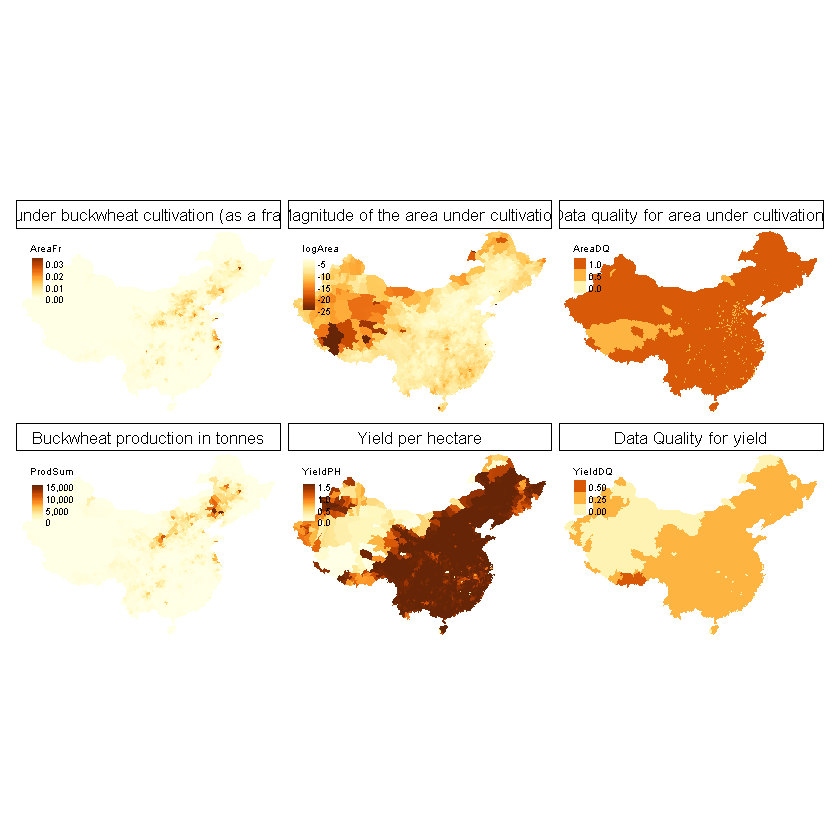

In [40]:
prod_maps<-tm_shape(china) +
    tm_fill(col=c("AreaFr","logArea","AreaDQ","ProdSum","YieldPH","YieldDQ"),style = c("cont","cont","cat","cont","cont","cat"),legend.reverse = c(TRUE,TRUE,FALSE,TRUE,FALSE,FALSE),palette=c("YlOrBr"),showNA = F)+
    tm_layout(panel.labels=c("Area under buckwheat cultivation (as a fraction)", "Magnitude of the area under cultivation","Data quality for area under cultivation ","Buckwheat production in tonnes","Yield per hectare","Data Quality for yield"),panel.label.bg.color="white",
              frame=FALSE,legend.outside.size=0.15,legend.outside = FALSE,legend.text.size = 0.8,
              panel.label.size = 1.5,legend.title.size=1)+
    tm_facets(ncol=3)
prod_maps

In [97]:
m1<-tm_shape(china) +
    tm_fill(col=c("AreaFr"),style = c("cont"),legend.reverse = TRUE,palette=c("YlOrBr"),showNA = F,title ="Area fraction")+
    tm_shape(china_sf)+
    tm_borders(col="grey",lwd=0.5)+    
    tm_layout(frame=FALSE,legend.title.size = 0.8,legend.text.size = 0.6)

In [98]:
m2<-tm_shape(china) +
    tm_fill(col=c("logArea"),style = c("cont"),legend.reverse = TRUE,palette=c("-YlOrBr"),showNA = F,title ="Magnitude of\narea fraction")+
     tm_shape(china_sf)+
    tm_borders(col="grey",lwd=0.5)+     
    tm_layout(frame=FALSE,legend.title.size = 0.8,legend.text.size = 0.6)

In [99]:
m3<-tm_shape(china) +
    tm_fill(col=c("AreaDQ"),style = c("cat"),legend.reverse = TRUE,showNA = F,title ="Data quality:\narea under cultivation",
            palette=c("thistle1","tomato3","tomato4"),labels=c("missing census data","interpolated (within 2° lat/lon)","county level data"))+
    tm_shape(china_sf)+
    tm_borders(col="grey",lwd=0.5)+     
    tm_layout(frame=FALSE,legend.title.size = 0.8,legend.text.size = 0.6)

In [100]:
m4<-tm_shape(china) +
    tm_fill(col=c("ProdSum"),style = c("cont"),legend.reverse = TRUE,palette=c("YlOrBr"),showNA = F,title ="Buckwheat production in tons")+
    tm_shape(china_sf)+
    tm_borders(col="grey",lwd=0.5)+    
    tm_layout(frame=FALSE,legend.title.size = 0.8,legend.text.size = 0.6)

In [101]:
m5<-tm_shape(china) +
    tm_fill(col=c("YieldPH"),style = c("cont"),legend.reverse = TRUE,palette=c("YlOrBr"),showNA = F,title ="Yield per hectare")+
    tm_shape(china_sf)+
    tm_borders(col="grey",lwd=0.5)+    
    tm_layout(frame=FALSE,legend.title.size = 0.8,legend.text.size = 0.6)

In [84]:
unique(china@data$YieldDQ)

[1] 0.25 0.00 0.50

In [102]:
m6<-tm_shape(china) +
    tm_fill(col=c("YieldDQ"),style = c("cat"),legend.reverse = TRUE,showNA = F,title ="Data quality:\nyield",
            palette=c("thistle1","tomato2","tomato3"),labels=c("missing census data","country level data","interpolated (within 2° lat/lon)"))+
    tm_shape(china_sf)+
    tm_borders(col="grey",lwd=0.5)+     
    tm_layout(frame=FALSE,legend.title.size = 0.8,legend.text.size = 0.6)
#m6

In [103]:
width=33.867
height=19.5
png("outputs/diag_maps.png", units="cm", width=width, height=height,res=300)
tmap_arrange(m1,m2,m3,m4,m5,m6, ncol=3)
dev.off()

png 
  2

In [ ]:
pred_maps<-tm_shape(china_sf) +
    tm_fill(col=periods, title.col="Period",style = "cont",legend.reverse = TRUE,palette="-RdYlBu",title = "SUITABILITY OF\nENVIRONMENTAL\nCONDITIONS",labels=c("low","","","","","","","","","","","","","","","","","","","","","","","","","high"),showNA = F) +
    tm_shape(outer_border)+
    tm_borders(col="grey",lwd=0.5)+
    tm_shape(macros)+
    tm_symbols(col ="Sample_type", shape="Sample_type",size=0.6,legend.col.show=FALSE,legend.shape.show=FALSE,palette=c("lightgreen","red","cornflowerblue","darkviolet"),shapes = c(17,4,15,16))+
    tm_facets(by = "period",free.scales=FALSE,free.coords=FALSE,ncol=3)+
    tm_shape(inner_border)+
    tm_borders(col="black",lwd=0.5,lty="dashed")+
    tm_facets(by = "period",free.scales=FALSE,free.coords=FALSE,ncol=3)+
    tm_add_legend("symbol",shape=c(17,15,16,4,17), col = c("lightgreen","cornflowerblue","darkviolet","red","white"), size = c(0.8,0.8,0.8,0.8),labels = c("charred seeds", "pollen","starch","\nF.tataricum\ncharred seeds",""))+
    tm_layout(panel.labels=c("1000 BP", "2000 BP","3000 BP","4000 BP","5000 BP","6000 BP"),panel.label.bg.color="white",
              frame=FALSE,legend.outside.size=0.15,legend.outside = TRUE,legend.text.size = 0.8,
              panel.label.size = 1.5,legend.title.size=1)

In [104]:
colnames(china@data)

[1] "ID_0"      "ISO"       "NAME_0"    "ID_1"      "NAME_1"    "ID_2"     
 [7] "NAME_2"    "ID_3"      "NAME_3"    "TYPE_3"    "ENGTYPE_3" "NL_NAME_3"
[13] "VARNAME_3" "BIO10"     "BIO17"     "BIO4"      "BIO9"      "npp"      
[19] "BIO10_sd"  "BIO17_sd"  "BIO4_sd"   "BIO9_sd"   "npp_sd"    "AreaDQ"   
[25] "YieldDQ"   "AreaFr"    "AreaHaS"   "AreaHaM"   "ProdSum"   "ProdMean" 
[31] "YieldPH"   "area"      "AreaPr"    "ProdHa"    "logArea"   "logProd"

In [116]:
pred_maps<-tm_shape(china) +
    tm_fill(col=c("BIO10","BIO17","BIO4","BIO9","npp"), title=c("°C","mm","°C","°C","g C m−2 yr−1"),style = "cont",legend.reverse = TRUE,palette="-RdYlBu",showNA = F) +
    #tm_shape(outer_border)+
    #tm_borders(col="grey",lwd=0.5)+
    tm_facets(free.scales=TRUE,free.coords=TRUE,ncol=3)+
    tm_layout(panel.labels=c("BIO10", "BIO17","BIO4","BIO9","npp"),panel.label.bg.color="white",
              frame=FALSE,legend.outside.size=0.15,legend.outside = FALSE,legend.text.size = 0.8,
              panel.label.size = 1.5,legend.title.size=1,legend.position=c("left","bottom"))

In [117]:
width=20
height=19.5
png("outputs/climate_maps.png", units="cm", width=width, height=height,res=300)
pred_maps
dev.off()

Variable(s) "BIO9" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.



png 
  2

## Calculate and save the adjacency matrix

In [ ]:
### Calculate the adjacency matrix for the Spatial Polygons Data Frame:

#### Now also get the adjacency matrix between the nodes and save it as csv:
# Gets the numbe of observations
N=nrow(china@data)

# Gets the adjacency
adj<-poly2nb(china)

# Define the nodes as vectors

node2 = vector(mode="numeric");
node1 = vector(mode="numeric");

# Get the values for each node
for (i in 1:N){
    a<-unlist(adj[i])
    a<-a[a>i]
    # Add to values of Node 1
    n1<-rep(i,length(a))
    node1 <-c(node1,n1)
    # Add values of Node 2
    node2<-c(node2,a)
}

mat<-cbind(node1, node2)
write.csv(mat, file=path2adjacency,row.names = FALSE)

In [ ]:
pred_maps<-tm_shape(china) +
    tm_fill(col=c("BIO10","BIO17","BIO4","BIO9","npp"), title=c("°C","mm","°C","°C","g C m−2 yr−1"),style = "cont",legend.reverse = TRUE,palette="-RdYlBu",showNA = F) +
    #tm_shape(outer_border)+
    #tm_borders(col="grey",lwd=0.5)+
    tm_facets(free.scales=TRUE,free.coords=TRUE,ncol=3)+
    tm_layout(panel.labels=c("BIO10", "BIO17","BIO4","BIO9","npp"),panel.label.bg.color="white",
              frame=FALSE,legend.outside.size=0.15,legend.outside = FALSE,legend.text.size = 0.8,
              panel.label.size = 1.5,legend.title.size=1,legend.position=c("left","bottom"))

## Visualise data

In [ ]:
# Finally, visualise some of the data:
#spplot(china['BIO_1'] )
spplot(china['BIO10'] )
spplot(china['logArea'] )

In [5]:
names(prd)

[1] "buckwheat_DataQuality_HarvestedArea" "buckwheat_DataQuality_Yield"        
[3] "buckwheat_HarvestedAreaFraction"     "buckwheat_HarvestedAreaHectares"    
[5] "buckwheat_Production"                "buckwheat_YieldPerHectare"

In [7]:
prd[[1]]

class      : RasterLayer 
dimensions : 426, 736, 313536  (nrow, ncol, ncell)
resolution : 0.08333333, 0.08333333  (x, y)
extent     : 73.5, 134.8333, 18.08333, 53.58333  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : G:/My Drive/SDM_China/data/buckwheat_production/masked/buckwheat_DataQuality_HarvestedArea.tif 
names      : buckwheat_DataQuality_HarvestedArea 
values     : 0, 1  (min, max)


In [8]:
china<-readOGR(dsn="data/china_data", layer="china_data")

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\SDM_China\data\china_data", layer: "china_data"
with 2409 features
It has 36 fields


In [9]:
head(china)

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,TYPE_3,...,AreaHaS,AreaHaM,ProdSum,ProdMean,YieldPH,area,AreaPr,ProdHa,logArea,logProd
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,49,CHN,China,1,Anhui,1,Anqing,1,Anqing,XiÃ njÃ­shÃ¬,...,19.9798486232758,3.32997477054596,31.9677577018738,5.32795961697896,1.60000002384186,458885245,0.0004353997,0.0006966395,-7.739246,-7.269243
1,49,CHN,China,1,Anhui,1,Anqing,2,Huaining,XiÃ n,...,75.8920187652111,3.16216744855046,121.427231490612,5.0594679787755,1.60000002384186,1611724621,0.0004708746,0.0007533994,-7.660919,-7.190915
2,49,CHN,China,1,Anhui,1,Anqing,3,Qianshan,XiÃ n,...,40.9308110401034,1.7796004800045,65.4892988801003,2.84736082087392,1.60000002384186,1711132484,0.0002392031,0.0003827249,-8.338198,-7.868194
3,49,CHN,China,1,Anhui,1,Anqing,4,Susong,XiÃ n,...,31.2180165797472,1.07648333033611,49.9488275945187,1.72237336532823,1.48965519461138,2354233624,0.0001326037,0.0002121660,-8.928145,-8.458142
4,49,CHN,China,1,Anhui,1,Anqing,5,Taihu,XiÃ n,...,52.5311418622732,1.94559784675086,84.0498283207417,3.11295660447191,1.60000002384186,2025878814,0.0002593005,0.0004148808,-8.257523,-7.787519
5,49,CHN,China,1,Anhui,1,Anqing,6,Tongcheng,XiÃ njÃ­shÃ¬,...,18.6689179092646,0.811692083011503,29.8702690713108,1.29870735092655,1.53043480541395,1647492859,0.0001133171,0.0001813074,-9.085320,-8.615316


In [11]:
colnames(china@data)

[1] "ID_0"      "ISO"       "NAME_0"    "ID_1"      "NAME_1"    "ID_2"     
 [7] "NAME_2"    "ID_3"      "NAME_3"    "TYPE_3"    "ENGTYPE_3" "NL_NAME_3"
[13] "VARNAME_3" "BIO10"     "BIO17"     "BIO4"      "BIO9"      "npp"      
[19] "BIO10_sd"  "BIO17_sd"  "BIO4_sd"   "BIO9_sd"   "npp_sd"    "AreaDQ"   
[25] "YieldDQ"   "AreaFr"    "AreaHaS"   "AreaHaM"   "ProdSum"   "ProdMean" 
[31] "YieldPH"   "area"      "AreaPr"    "ProdHa"    "logArea"   "logProd"

In [16]:
summary(china@data$YieldDQ)

0 0.25  0.5 
 100 2276   33

In [15]:
2152+252+5

[1] 2409